In [1]:
import os
os.chdir("..")
ROOT = os.getcwd()
DIR_DATA = os.path.join(ROOT, "data")
PATH_IMG = os.path.join(DIR_DATA, "raw", "fire_ant_activity", "A1", "A1_1.JPEG")
print("ROOT:", ROOT)

ROOT: /Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_03_Papers/2023/finding_ants


In [2]:
from libs import split_img, compute_area, get_quantile_area
from PIL import Image
image = Image.open(PATH_IMG)

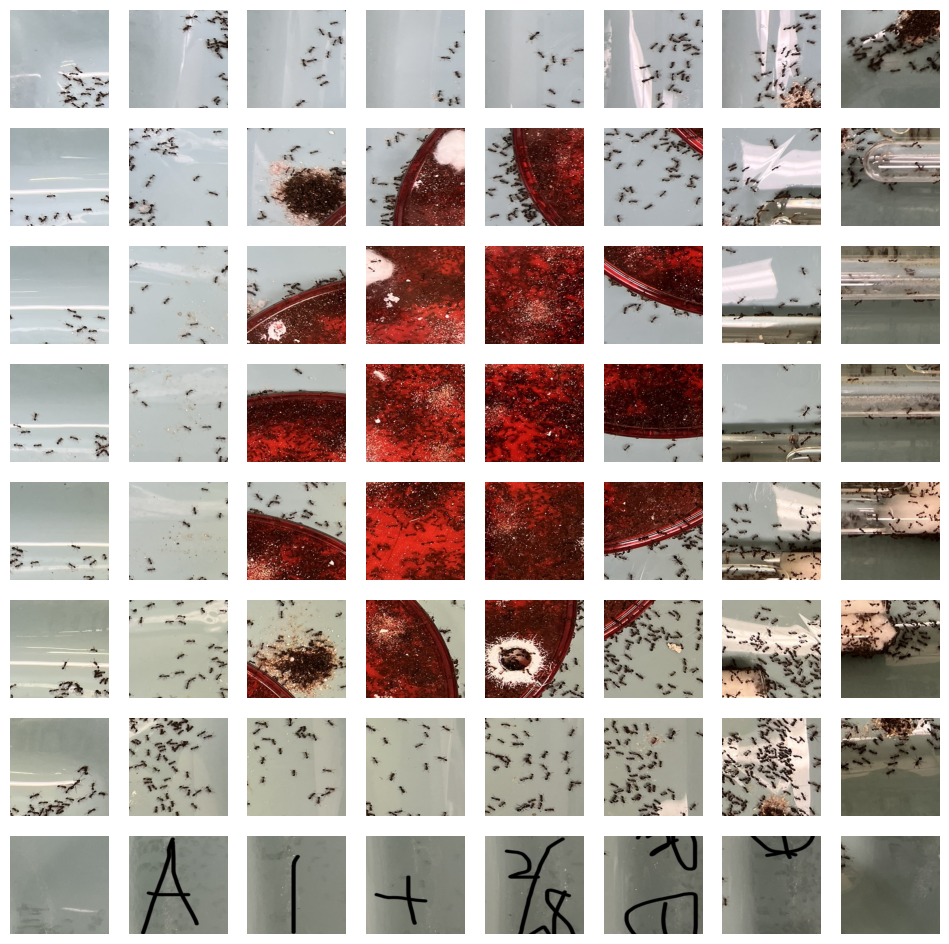

In [3]:
import supervision as sv
RATE = 8
ls_imgs = split_img(image, rate=RATE, newsize=(640, 640))
sv.plot_images_grid(
    ls_imgs,
    grid_size=(RATE, RATE),
)

In [4]:
from ultralytics import YOLO
from detections import Niche_CV_Object
DEVICE = "mps"
model = YOLO(os.path.join(ROOT, "models", "yolov8m.pt"))

In [5]:
results = model.predict(ls_imgs, device=DEVICE)


0: 640x640 (no detections), 1: 640x640 3 birds, 2 kites, 2: 640x640 4 birds, 3: 640x640 4 birds, 1 kite, 4: 640x640 5 birds, 3 kites, 5: 640x640 1 bird, 6: 640x640 1 kite, 7: 640x640 (no detections), 8: 640x640 2 birds, 9: 640x640 4 birds, 1 kite, 10: 640x640 2 birds, 1 cake, 11: 640x640 1 bird, 12: 640x640 (no detections), 13: 640x640 3 birds, 1 fork, 14: 640x640 5 birds, 15: 640x640 (no detections), 16: 640x640 2 birds, 17: 640x640 3 kites, 18: 640x640 1 person, 1 bird, 1 kite, 19: 640x640 (no detections), 20: 640x640 (no detections), 21: 640x640 (no detections), 22: 640x640 6 kites, 23: 640x640 1 bird, 24: 640x640 6 birds, 2 kites, 25: 640x640 1 person, 5 birds, 26: 640x640 (no detections), 27: 640x640 (no detections), 28: 640x640 (no detections), 29: 640x640 (no detections), 30: 640x640 1 bird, 1 kite, 31: 640x640 1 person, 32: 640x640 8 birds, 33: 640x640 1 bird, 3 kites, 34: 640x640 1 bird, 35: 640x640 (no detections), 36: 640x640 (no detections), 37: 640x640 1 skis, 38: 640x640

In [6]:
thred = get_quantile_area(results, quantile=0.8)
print("thred:", thred)

thred: 5050.42041015625


In [7]:
from models.sam import init_sam
sam_predictor = init_sam()

In [31]:
ls_det = []
for i, result in enumerate(results):
    xyxy = result.boxes.xyxy.cpu().numpy()
    obj = Niche_CV_Object(ls_imgs[i], xyxy, thred)
    # obj.set_mask_by_sam(sam_predictor)
    ls_det.append(obj)

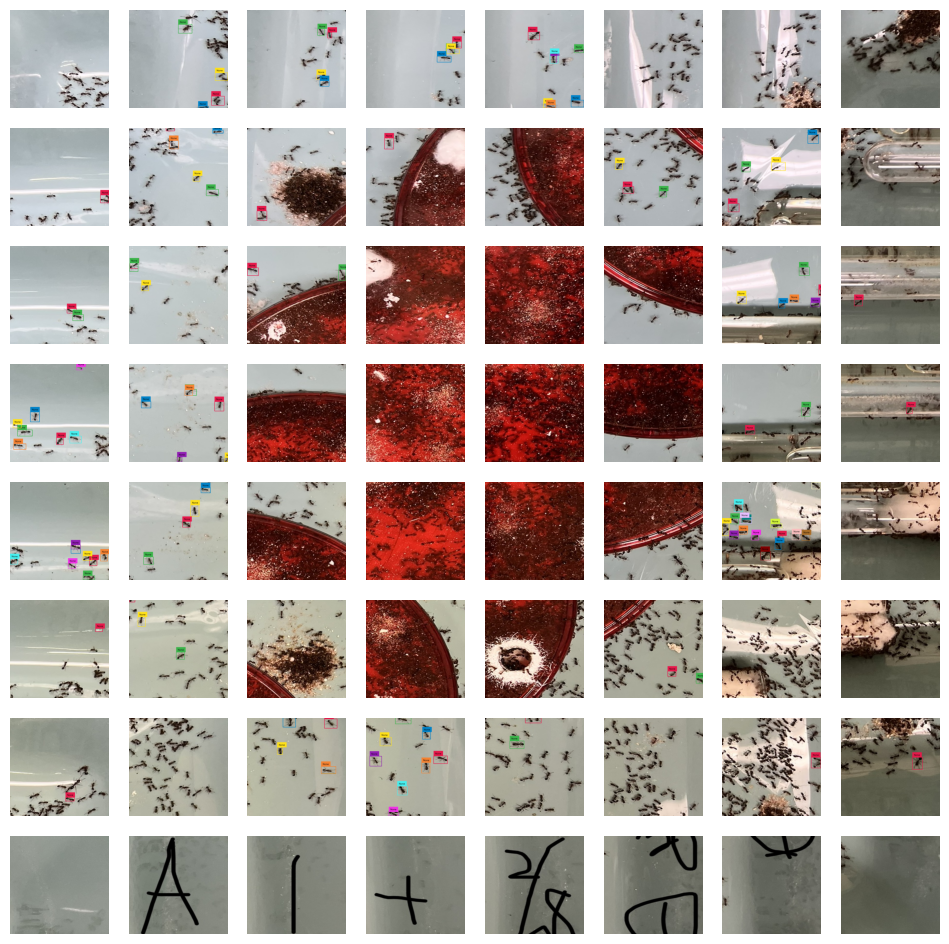

In [12]:
sv.plot_images_grid(
    [det.get_annotated_img() for det in ls_det],
    grid_size=(RATE, RATE),
)

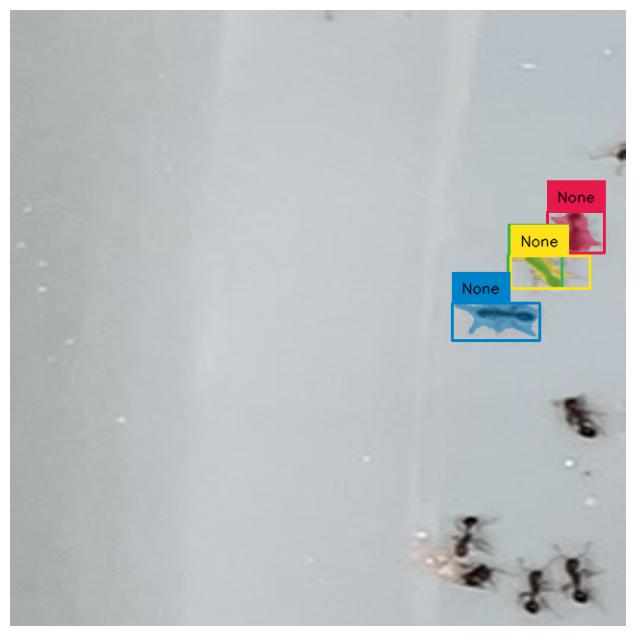

In [32]:
det = ls_det[3]
det.set_mask_by_sam(sam_predictor)
det.plot_image()

In [101]:
from matplotlib import pyplot as plt
import numpy as np
import random
def paste_objects(image, mask_list, xyxy_list, canvas_size=(640, 640, 3)):
    # Create an empty canvas
    canvas = np.zeros(canvas_size, dtype=np.uint8)
    h, w, d = canvas_size

    for mask, xyxy in zip(mask_list, xyxy_list):
        # Extract the object from the mask using the bounding box
        x1, y1, x2, y2 = xyxy
        # extend mask to 3 channels
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        obj = np.multiply(mask, image)[y1:y2, x1:x2]
        # randomly rotate
        angle = random.randint(0, 360)
        obj = Image.fromarray(obj)
        obj = obj.rotate(angle)
        obj = np.array(obj)
        oh, ow, _ = obj.shape
        
        # Randomly choose a position in the canvas where the object will be pasted
        max_x = w - ow
        max_y = h - oh
        pos_x = random.randint(0, max_x)
        pos_y = random.randint(0, max_y)

        # Paste the object onto the canvas
        canvas[pos_y:pos_y + oh, pos_x:pos_x + ow] += obj

    # set background by avg color
    idx_non_black = np.any(canvas != [0, 0, 0], axis=-1)
    idx_black = np.all(canvas == [0, 0, 0], axis=-1)
    # Get the non-black pixels.
    non_black_pixels = canvas[idx_non_black]
    # Compute and return the average color.
    avg_color = non_black_pixels.mean(axis=0)
    # Set the black pixels to the average color.
    canvas[idx_black] = avg_color
    return canvas

[     108.76      109.27      113.18]
640
640


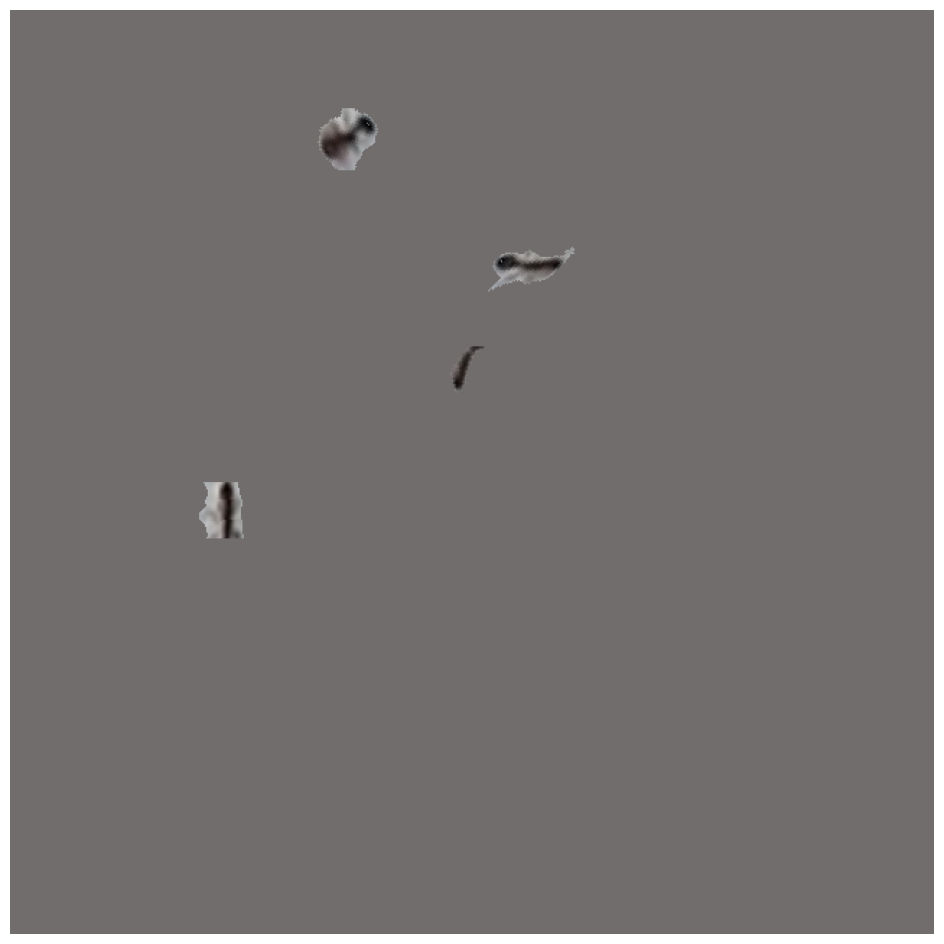